# Predicting Benign and Malignant Skin Lesions Using Images and Patient Data

**Due: December 9th at 11:59pm**

In [1]:
# CPSC 66 - Machine Learning
# Final Project
# Ana Castano, Francisco Lopez, Xezel Peshlakai, Victor Sumano
# Resources used: 
# 

In [2]:
# import pandas
import pandas as pd
# import math and numpy first
import math
import numpy as np
# import scipy for stats package
import scipy
# import some data and classifiers to play with; you may want to add more
from sklearn import datasets
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import neural_network
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
import random
# import some validation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import itertools
%matplotlib widget

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')

# Load, Process, and Split Data

## Load Data

In [3]:
# load data
def loadData(): 
    patient_data = pd.read_csv('/home/xpeshla1/scratch/skin_lesion/ISIC_2020_Training_GroundTruth_v2.csv')
    pd.set_option('future.no_silent_downcasting', True)

    return patient_data

## Split Train and Test Sets

In [10]:
def createSets(patient_data):
    # get test set
    image_ids = pd.read_csv('image-classification/testing_ids3.csv')['Image_ID']

    test = patient_data[patient_data['image_name'].isin(image_ids)]

    train = patient_data[~patient_data['image_name'].isin(image_ids)]
    
    # convert the column of image IDs to a list
    ordered_image_ids = image_ids.tolist()
    
    # reorder the test set to match the order in `ordered_image_ids`
    test_ordered = test.set_index('image_name').reindex(ordered_image_ids).reset_index()
    
    return train, test_ordered

## Process the Data (One-Hot Encoding)

In [11]:
def processData(patient_data):
          
    # filling in empty columns (numeric)
    imputer = SimpleImputer(strategy='mean')  # replace with the mean
    patient_data.loc[:, 'age_approx'] = imputer.fit_transform(patient_data[['age_approx']])
    
    # filling in empty columns (discrete)
    patient_data.loc[:, 'anatom_site_general_challenge'] = patient_data['anatom_site_general_challenge'].fillna('unknown')
    
    # one-hot encoding >> turn categorical data into numeric data
    categorical_cols = ['sex', 'anatom_site_general_challenge']
    patient_data = pd.get_dummies(patient_data, columns=categorical_cols, drop_first=False, dummy_na=False) 
    
    patient_data['sex_male'] = patient_data['sex_male'].replace({True: 1, False: 0})
    patient_data['sex_female'] = patient_data['sex_female'].replace({True: 1, False: 0})
    patient_data['anatom_site_general_challenge_lower extremity'] = patient_data['anatom_site_general_challenge_lower extremity'].replace({True: 1, False: 0})
    patient_data['anatom_site_general_challenge_oral/genital'] = patient_data['anatom_site_general_challenge_oral/genital'].replace({True: 1, False: 0})
    patient_data['anatom_site_general_challenge_head/neck'] = patient_data['anatom_site_general_challenge_head/neck'].replace({True: 1, False: 0})
    patient_data['anatom_site_general_challenge_palms/soles'] = patient_data['anatom_site_general_challenge_palms/soles'].replace({True: 1, False: 0})
    patient_data['anatom_site_general_challenge_torso'] = patient_data['anatom_site_general_challenge_torso'].replace({True: 1, False: 0})
    patient_data['anatom_site_general_challenge_unknown'] = patient_data['anatom_site_general_challenge_unknown'].replace({True: 1, False: 0})
    patient_data['anatom_site_general_challenge_upper extremity'] = patient_data['anatom_site_general_challenge_upper extremity'].replace({True: 1, False: 0})

    patient_data.columns = patient_data.columns.str.strip()
    pd.set_option("future.no_silent_downcasting", True)

    return patient_data

## Rebalance Data

In [12]:
def rebalanceData(patient_data):
    # get indices of benign examples
    inds = patient_data[patient_data['benign_malignant']=='benign'].index.tolist()

    # get random indices from this to equal number of malignant examples (500)
    remove = random.sample(inds, 32000)
    
    # drop all of these examples
    patient_data = patient_data.drop(remove) 

    return patient_data

## Drop Columns and Get Labels

In [13]:
def dropColumns(patient_data):
    # split into X and y (drop all target-ish columns)
    X = patient_data.drop(columns=['target', 'image_name', 'patient_id', 'lesion_id', 'diagnosis', 'benign_malignant'])  # All columns except the target
    y = patient_data['target']  

    return X, y

## getSets()

In [14]:
"""
purpose: load, split into training and testing example sets, process data, rebalance training data, drop cols
params: none
returns: X_train - training set without labels
         y_train - training set labels
         X_test - testing set without labels
         y_test - testing set labels
         num_features - number of features in X_train
"""
def getSets():
    # load dataset
    patient_data = loadData()
    
    # create train and test sets
    train, test = createSets(patient_data)
    
    # process the train and test data
    train = processData(train)
    test = processData(test)
    
    # rebalance train set
    train = rebalanceData(train)
    
    # drop columns in train and test set
    X_test, y_test = dropColumns(test)
    X_train, y_train = dropColumns(train)

    # get the number of features
    num_features = X_train.shape[1]

    return X_train, y_train, X_test, y_test, num_features

# Code Bank for Initializing Classifiers

In [15]:
X_train, y_train, X_test, y_test, num_features = getSets()

# create, train, and test a nearest neighbor classifier
classifier_knn = neighbors.KNeighborsClassifier(metric='euclidean', n_neighbors=1)
classifier_knn.fit(X_train, y_train)
print("knn:", classifier_knn.score(X_test, y_test))

# create, train, and test random forest
classifier_rf = ensemble.RandomForestClassifier()
classifier_rf.fit(X_train, y_train)
print("rf:", classifier_rf.score(X_test, y_test))

# create, train, and test adaboost
classifier_ab = ensemble.AdaBoostClassifier(algorithm='SAMME')
classifier_ab.fit(X_train, y_train)
print("adaboost:", classifier_ab.score(X_test, y_test))

# create, train, and test svc
classifier_svc = svm.LinearSVC()
classifier_svc.fit(X_train, y_train)
print("svc:", classifier_svc.score(X_test, y_test))

# create, train, and test neural network
classifier_nn = neural_network.MLPClassifier()
classifier_nn.fit(X_train, y_train)
print("neural network:", classifier_nn.score(X_test, y_test))

knn: 0.5982905982905983
rf: 0.6239316239316239
adaboost: 0.6282051282051282
svc: 0.6794871794871795
neural network: 0.688034188034188


# Hyperparameter Tuning

## runTuneTest
Tune a given classifier

In [16]:
"""
purpose: creates train/tune/test sets and performs end-to-end training and evaluation
params: learner - baser learner
        params - hyperparameters to tune
        X - data
        y - targets
returns: scores - accuracy scores for each fold in analysis
"""
def runTuneTest(learner, param_grid, X, y):  
    # variables
    fold_results = []  # store results for each fold
    best_score = 0
    
    # divide data into train/test splits (shuffle data, 5 folds for validation, random state = 42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print(f"Running {learner.__class__.__name__}")
    skf_split = skf.split(X, y)
    
    # begin folding and tuning
    for train_i, test_i in skf.split(X, y):
        X_train, X_test = X.iloc[train_i], X.iloc[test_i] # current train / test data split
        y_train, y_test = y.iloc[train_i], y.iloc[test_i] # current train / test labels

        # run GridSearchCV on current train set to find best combo of params
        gs = GridSearchCV(learner, param_grid=param_grid, cv=5, n_jobs=-1)
        gs.fit(X_train, y_train)
        
        # find best parameters
        best_params = gs.best_params_

        # run GridSearchCV on current test set and measure accuracy
        tune_score = gs.score(X_test, y_test)
        
        # add result to fold_results
        fold_results.append((tune_score, best_params))

        if tune_score > best_score:
            best_model = gs.best_estimator_
            best_score = tune_score

        # print out info

        #print(f"Best parameters: {best_params}")
        #print(f"Tuning Set Score: {tune_score:.3f}")
    
    return fold_results, best_model

## runPipeline
Give runTuneTest a parameter grid to tune

In [17]:
"""
purpose: load data and run dataset through analysis pipeline using Random Forests and SVC
params: dataset - name of dataset to load
returns: rf_scores - random forest score
         svc_scores - support vector classifier score
"""
def runPipeline(c_name, X, y, num_features):

    if c_name == "rf":
        c = ensemble.RandomForestClassifier(n_estimators=200, random_state=42)
        param_grid = {'max_features': [int(math.sqrt(num_features)), 0.01, 0.1, 0.5, 0.75, 1.0]}
    
    elif c_name == "knn":
        c = neighbors.KNeighborsClassifier(metric='euclidean')
        param_grid = {'n_neighbors': [1, 5, 11]}
    
    elif c_name == "ab":
        c = ensemble.AdaBoostClassifier(algorithm='SAMME')
        param_grid = {'n_estimators': [1, 2, 3, 4, 5, 10, 11, 12, 20, 30]}
    
    elif c_name == "svc":
        c = svm.LinearSVC(random_state=42)
        param_grid = {'C': [0.1, 1, 10, 100]}
    
    elif c_name == "nn":
        c = neural_network.MLPClassifier(max_iter=1000)
        param_grid = {'hidden_layer_sizes': [(10,30,10),(20,)],'activation': ['tanh', 'relu'],'solver': ['sgd', 'adam'],'alpha': [0.0001, 0.05],'learning_rate': ['constant','adaptive'],}
    
    else:
        print("Please choose one of the five specified classifiers.")
        return 
      
    # call runTuneTest
    results, best_model = runTuneTest(c, param_grid, X, y)
    scores = []

    # print results
    #print("\nTest set results")
    #print("-----------------")
    #print("Fold")
    for result in results:
        #print(result)
        scores.append(result[0])
    #print("-----------------\n")
    # get list of results to return (for analysis)
    
    return scores, best_model

## Test runTuneTest and runPipeline
Load dataset, rebalance data, then runPipeline for a specific classifier

In [18]:
"""
pick which classifier you want to runPipeline on: 
 Random Forest: rf
 KNN: knn
 AdaBoost: ab
 Linear SVM: svc
 Neural Net: nn
"""
"""
runPipeline("rf", X, y)
runPipeline("knn", X, y)
runPipeline("ab", X, y)
runPipeline("svc", X, y)
runPipeline("nn", X, y)
"""

'\nrunPipeline("rf", X, y)\nrunPipeline("knn", X, y)\nrunPipeline("ab", X, y)\nrunPipeline("svc", X, y)\nrunPipeline("nn", X, y)\n'

# Get Best Predictions

In [19]:
def getBestPredictions(c_name):
    X_train, y_train, X_test, y_test, num_features = getSets()
    scores, best_model = runPipeline(c_name, X_train, y_train, num_features)
    predictions = best_model.predict(X_test)

    return predictions, X_train, y_train, X_test, y_test, num_features, best_model

# Evaluation

## Confusion Matrix

In [20]:
"""
purpose: return confusion matrix when given correct labels and predicted labels
params: y_test - test set labels
        predictions - test predictions
returns: confMat - confusion matrix 
"""
def getConfusionMatrix(y_test, predictions):
    confMat = confusion_matrix(y_test, predictions)

    return confMat

In [21]:
"""
purpose: print and plot confusion matrix
params: cm - confusion matrix
        classes - benign and malignant
returns: none
"""
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
def plotMatrix(confMat):
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(confMat, classes=['benign', 'malignant'],
                          title='Confusion matrix, without normalization')
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(confMat, classes=['benign', 'malignant'], normalize=True,
                          title='Normalized confusion matrix')
    
    plt.show()
    
    tp = confMat[1][1]
    tn = confMat[0][0]
    fp = confMat[0][1]
    fn = confMat[1][0]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_1 = 2 * (precision * recall) / (precision + recall)
    
    print("Matrix Analysis:\n")
    print(f"precision = {precision}\nrecall = {recall}\nF_1 = {f_1}")

## Hypothesis Testing: P-Value

Generate p-values for results.

In [23]:
def getPVal(X, y):
    # lists for each classifier's results after running 5 times
    rf = []
    knn = []
    ab = []
    svc = []
    nn = []
    
    
    for i in range(5):
        rf.extend(runPipeline("rf", X, y, num_features)[0])
        knn.extend(runPipeline("knn", X, y, num_features)[0])
        ab.extend(runPipeline("ab", X, y, num_features)[0])
        svc.extend(runPipeline("svc", X, y, num_features)[0])
        nn.extend(runPipeline("nn", X, y, num_features)[0])

    results = [rf, knn, ab, svc, nn]
    results_name = ["rf", "knn", "ab", "svc", "nn"]
    
    for i in range(len(results)):
        for j in range(len(results)):
            if i != j and i < j:
                w, p = wilcoxon(results[i], results[j])
                print(f"p-value for {results_name[i]} and {results_name[j]}: {p}")

## K-Fold Cross Validation


In [24]:
"""
purpose: calculate the cross validation score for each classifier and get the predictions
params: c_name - classifier name
returns: cv_score - cross validation scores
"""
def classifier_cross_val(c_name, train, trainLabels, best_model): 
    cv_score = cross_val_score(best_model, train, trainLabels, cv=5)
    
    return cv_score

## TESTING: All Evaluation

Running RandomForestClassifier
cv_score is [0.61452514 0.64804469 0.65730337 0.64044944 0.64606742]



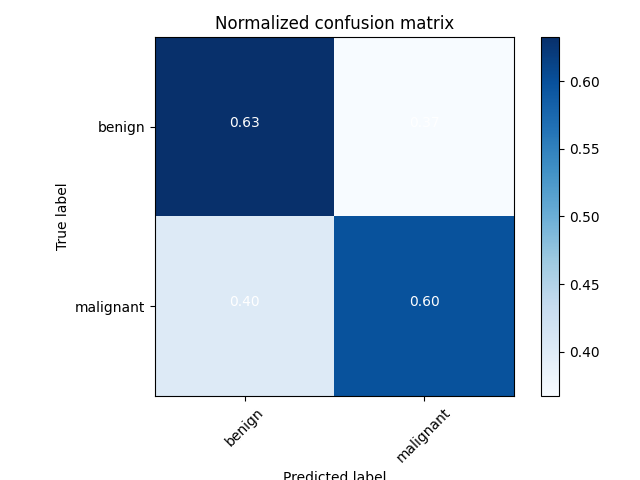

Matrix Analysis:

precision = 0.6194690265486725
recall = 0.5982905982905983
F_1 = 0.6086956521739131
Running KNeighborsClassifier
cv_score is [0.55307263 0.63687151 0.5505618  0.62921348 0.6741573 ]



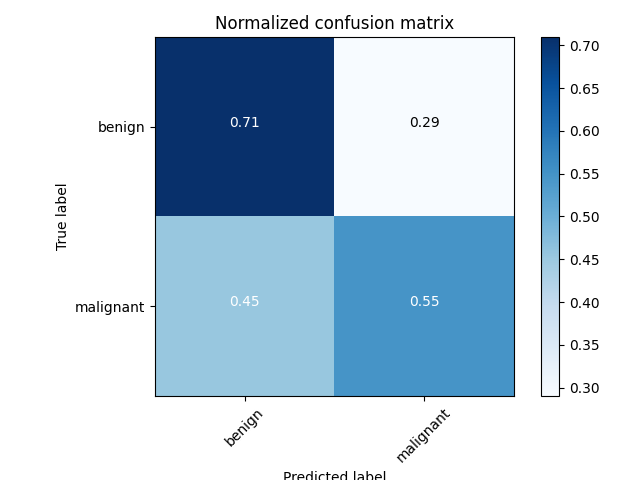

Matrix Analysis:

precision = 0.6530612244897959
recall = 0.5470085470085471
F_1 = 0.5953488372093022
Running AdaBoostClassifier
cv_score is [0.60335196 0.65921788 0.59550562 0.64044944 0.61235955]



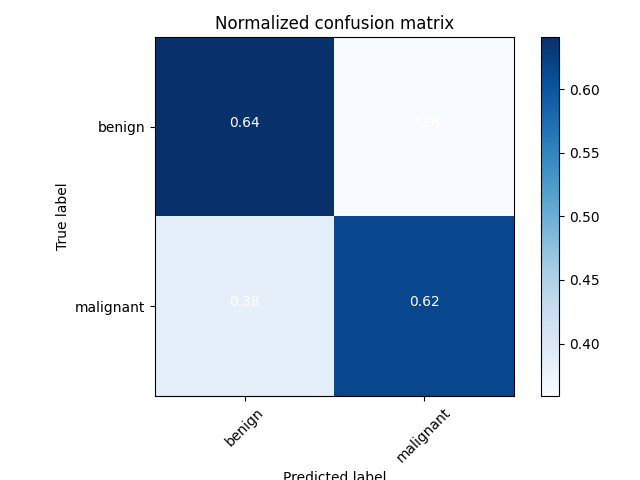

Matrix Analysis:

precision = 0.631578947368421
recall = 0.6153846153846154
F_1 = 0.6233766233766234
Running LinearSVC
cv_score is [0.60893855 0.67039106 0.62359551 0.62921348 0.62359551]



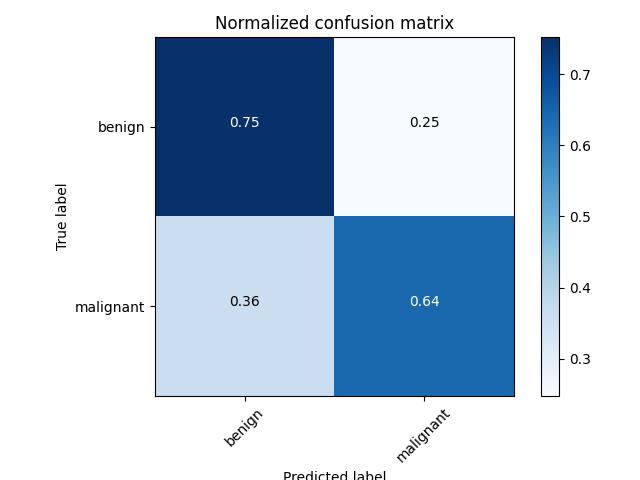

Matrix Analysis:

precision = 0.7211538461538461
recall = 0.6410256410256411
F_1 = 0.6787330316742082
Running MLPClassifier


/scratch/knerr/venvs/cs66-2404/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


cv_score is [0.66480447 0.7150838  0.61235955 0.61797753 0.71348315]



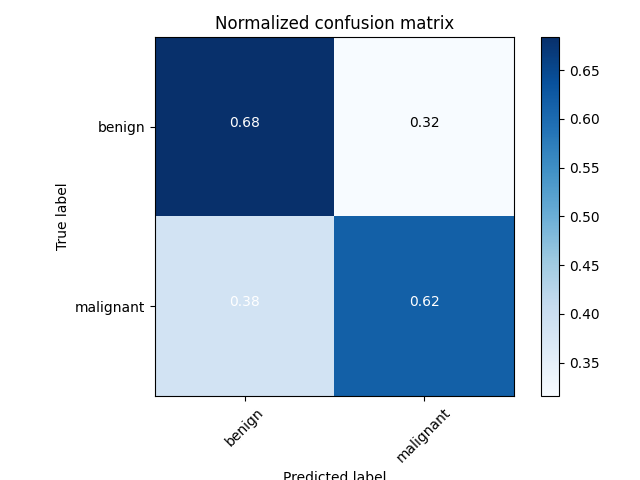

Matrix Analysis:

precision = 0.6605504587155964
recall = 0.6153846153846154
F_1 = 0.6371681415929203
Running RandomForestClassifier
Running KNeighborsClassifier
Running AdaBoostClassifier
Running LinearSVC
Running MLPClassifier
Running RandomForestClassifier
Running KNeighborsClassifier
Running AdaBoostClassifier
Running LinearSVC
Running MLPClassifier
Running RandomForestClassifier
Running KNeighborsClassifier
Running AdaBoostClassifier
Running LinearSVC
Running MLPClassifier
Running RandomForestClassifier
Running KNeighborsClassifier
Running AdaBoostClassifier
Running LinearSVC
Running MLPClassifier


/scratch/knerr/venvs/cs66-2404/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running RandomForestClassifier
Running KNeighborsClassifier
Running AdaBoostClassifier
Running LinearSVC
Running MLPClassifier
p-value for rf and knn: 0.8531995415687561
p-value for rf and ab: 0.12664812803268433
p-value for rf and svc: 8.803606033325195e-05
p-value for rf and nn: 0.0009734521872858115
p-value for knn and ab: 0.13262690598399335
p-value for knn and svc: 0.02550506591796875
p-value for knn and nn: 0.08276624358808157
p-value for ab and svc: 0.12664812803268433
p-value for ab and nn: 0.4401495248598286
p-value for svc and nn: 0.7647005616997816


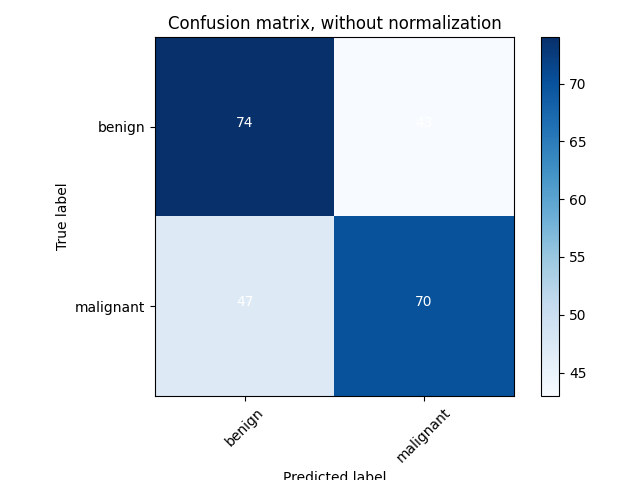

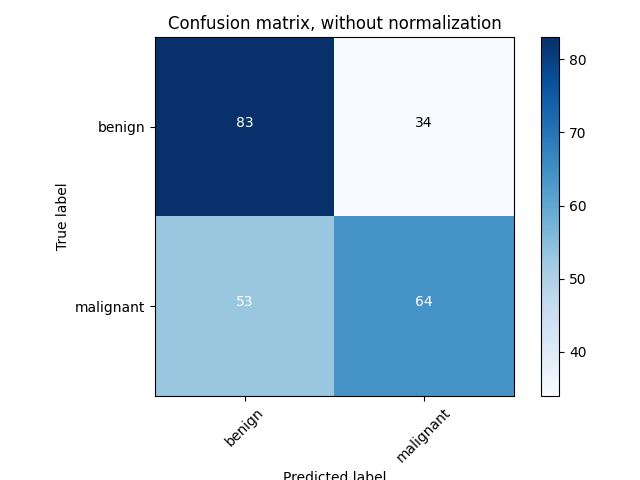

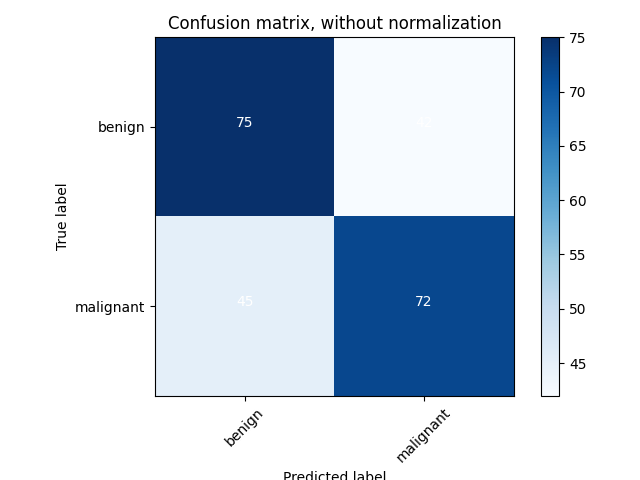

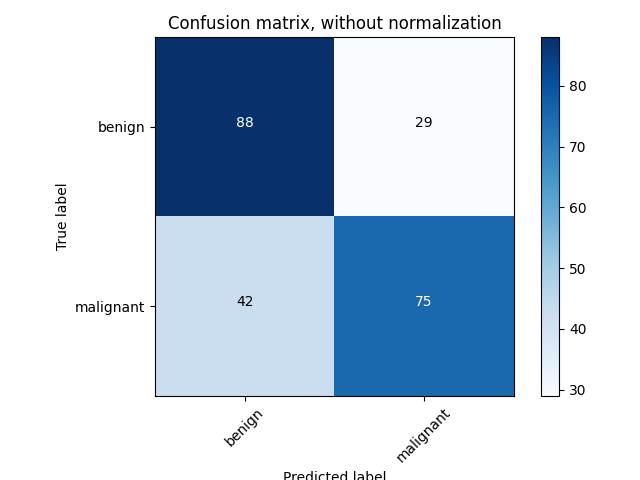

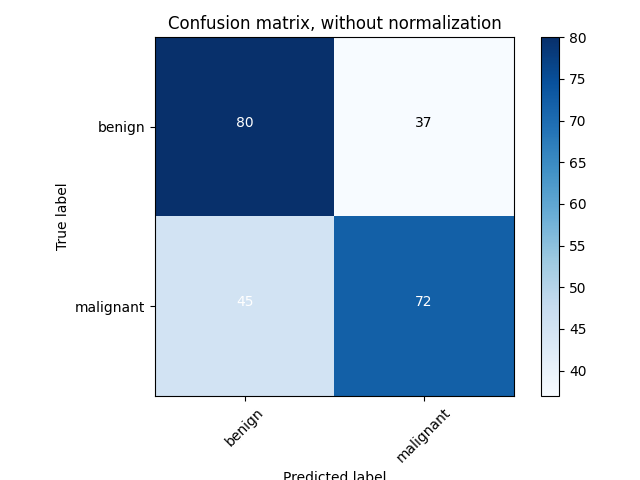

In [25]:
def crossAndCon(c_name):
    # get all necessary info
    predictions, X_train, y_train, X_test, y_test, num_features, best_model = getBestPredictions(c_name)
    
    # k-fold cross validation
    cv_rf = classifier_cross_val(c_name, X_train, y_train, best_model)
    print(f"cv_score is {cv_rf}\n")
    
    # plot confusion matrix
    confMat = getConfusionMatrix(y_test, predictions)
    plotMatrix(confMat)

    return X_train, y_train

X_train, y_train = crossAndCon("rf")
X_train, y_train = crossAndCon("knn")
X_train, y_train = crossAndCon("ab")
X_train, y_train = crossAndCon("svc")
X_train, y_train = crossAndCon("nn")

# test p-values
getPVal(X_train, y_train)

# Cross Comparison

In [32]:
"""
purpose: get true labels from img_names in cnn_predictions
params: patient_data - test data
returns: val_change - list of labels
"""
def getTrueLabels(): 
    patient_data = loadData()
    
    # get test set
    image_ids = pd.read_csv('image-classification/testing_ids3.csv')['Image_ID']

    test = patient_data[patient_data['image_name'].isin(image_ids)]
    
    # convert the column of image IDs to a list
    ordered_image_ids = image_ids.tolist() 
    
    # reorder the test set to match the order in `ordered_image_ids`
    test_ordered = test.set_index('image_name').reindex(ordered_image_ids).reset_index()

    # get label column
    labels = test_ordered['target'].tolist()

    return labels

In [33]:
def classifierComparisons(c_predict, cnn_predict, true_labels): 
    # results = { 
    #    0: 'cnn_b_c_b_actual_b': benign: cnn, c, t | malignant: 
    #    1: 'cnn_b_c_b_actual_m': benign: cnn, c    | malignant: t
    #    2: 'cnn_b_c_m_actual_b': benign: cnn, t    | malignant: c
    #    3: 'cnn_b_c_m_actual_m': benign: cnn       | malignant: c, t
    #    4: 'cnn_m_c_b_actual_b': benign: c, t      | malignant: cnn
    #    5: 'cnn_m_c_b_actual_m': benign: c         | malignant: cnn, t
    #    6: 'cnn_m_c_m_actual_b': benign: t         | malignant: cnn, c
    #    7: 'cnn_m_c_m_actual_m': benign:           | malignant: cnn, c, t
    # }

    results = np.zeros(8)
    
    # for loop through all of the predictions
    for i in range(len(true_labels)):
        # cnn benign && benign
        if cnn_predict[i][0] == 0 and c_predict[i] == 0: 
            if true_labels[i] == 0: 
                results[0] += 1
            else: 
                results[1] += 1
                
        # cnn benign && malignant
        elif cnn_predict[i][0] == 0 and c_predict[i] == 1: 
            if true_labels[i] == 0: 
                results[2] += 1
            else: 
                results[3] += 1
                
        # cnn malignant && benign
        elif cnn_predict[i][0] == 1 and c_predict[i] == 0: 
            if true_labels[i] == 0: 
                results[4] += 1
            else: 
                results[5] += 1
                
        # cnn malignant && malignant
        elif cnn_predict[i][0] == 1 and c_predict[i] == 1: 
            if true_labels[i] == 0: 
                results[6] += 1
            else: 
                results[7] += 1

    # alter results
    return results

In [34]:
def getPercentage(n, tot):
    return n/tot*100

In [35]:
def getComparisons(c_name, cnn_predict, predictions, test_labels):
    comparisons = classifierComparisons(predictions, cnn_predict, test_labels)

    print(f"Comparison list for {c_name} is {comparisons}")
    print(f"Both correct: {getPercentage(comparisons[0] + comparisons[7], len(test_labels))}")
    print(f"CNN correct: {getPercentage(comparisons[2] + comparisons[5], len(test_labels))}")
    print(f"{c_name} correct: {getPercentage(comparisons[3] + comparisons[4], len(test_labels))}")
    print(f"Both incorrect: {getPercentage(comparisons[1] + comparisons[6], len(test_labels))}")
    print(f"{c_name} predicts malignant correctly while CNN is incorrect: {getPercentage(comparisons[3], len(test_labels))}")
    print(f"Overall CNN Accuracy: {getPercentage(comparisons[0] + comparisons[7] + comparisons[2] + comparisons[5], len(test_labels))}")
    print(f"Overall {c_name} Accuracy: {getPercentage(comparisons[0] + comparisons[7] + comparisons[3] + comparisons[4], len(test_labels))}\n")
    
    

## TESTING: Comparisons

In [37]:
def evaluateAll(c_name, cnn_predict):
    predictions, X_train, y_train, X_test, y_test, num_features, best_model = getBestPredictions(c_name)
    test_labels = getTrueLabels()
    getComparisons(c_name, cnn_predict, predictions, test_labels)

    if (c_name == "svc"): 
        print(f"\nWeights for {c_name}\n")
        weights = best_model.coef_
        feature_names = list(X_train.columns)
        feature_weights = zip(feature_names, weights[0])
        sorted_features = sorted(feature_weights, key=lambda x: abs(x[1]), reverse=True)
        for feature, weights in sorted_features: 
            print(f"{feature}: {weights}")
        print("\n")

# read in cnn predictions
cnn_file = pd.read_csv('image-classification/cnn_predictions.csv')
cnn_predict = cnn_file.values.tolist()

evaluateAll("rf", cnn_predict)
evaluateAll("knn", cnn_predict)
evaluateAll("ab", cnn_predict)
evaluateAll("svc", cnn_predict)
evaluateAll("nn", cnn_predict)

Running RandomForestClassifier
Comparison list for rf is [57.  4. 33. 14. 13. 44. 14. 55.]
Both correct: 47.863247863247864
CNN correct: 32.9059829059829
rf correct: 11.538461538461538
Both incorrect: 7.6923076923076925
rf predicts malignant correctly while CNN is incorrect: 5.982905982905983
Overall CNN Accuracy: 80.76923076923077
Overall rf Accuracy: 59.401709401709404

Running KNeighborsClassifier
Comparison list for knn is [58.  5. 32. 13. 15. 40. 12. 59.]
Both correct: 50.0
CNN correct: 30.76923076923077
knn correct: 11.965811965811966
Both incorrect: 7.264957264957266
knn predicts malignant correctly while CNN is incorrect: 5.555555555555555
Overall CNN Accuracy: 80.76923076923077
Overall knn Accuracy: 61.965811965811966

Running AdaBoostClassifier
Comparison list for ab is [76.  8. 14. 10. 20. 60.  7. 39.]
Both correct: 49.14529914529914
CNN correct: 31.62393162393162
ab correct: 12.82051282051282
Both incorrect: 6.41025641025641
ab predicts malignant correctly while CNN is inco